In [51]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from dataclasses import dataclass, field
from typing import List, Dict
from collections import Counter

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)

@dataclass
class JoinAlgoExperiment:
  # Assume: 
  #   T different right table sizes in the experiment
  #   N different trials run on each left & right table

  # (T,) shape
  left_table_sizes: np.ndarray

  # (T,) shape
  right_table_sizes: np.ndarray
  
  # (T, N) shape
  trials_execution_times: np.ndarray

  max_trial_number: int

  # Fields for naming BNL Join
  left_block_sz: int
  right_block_sz: int

  def table_ratios(self) -> np.ndarray:
    return self.right_table_sizes / self.left_table_sizes

  def execution_time_avgs(self) -> np.ndarray:
    return np.average(self.trials_execution_times, axis=1)

  def execution_time_stddevs(self) -> np.ndarray:
    # stddev is too large on its own, so use sqrt of it
    return np.sqrt(np.std(self.trials_execution_times, axis=1))

In [52]:
# Parse profiling json output

profiling_data = []

base_path = "/home/ubuntu/6.830FinalProject/benchmark_joins/experiments"
for exp_name in os.listdir(base_path):
  print(exp_name)
  exp_data_json = f"{base_path}/{exp_name}/{exp_name}.json"
  with open(exp_data_json) as f:
    profiling_data.extend(json.load(f))

# Sort each experiment run by left, right table size and trial number
profiling_data.sort(key = lambda l: (l['outer_table']['num_records'], l['inner_table']['num_records'], l['trial_number']))

# Determine left table information
left_table_sizes = Counter(map(lambda r: r['outer_table']['num_records'], profiling_data))
num_left_table_sizes = len(left_table_sizes)

print()
print(f"Table size(s): {left_table_sizes}")

10K_left_select20
100M_left_select20
1M_left_select20
100K_left_select20
bnl_10K_left_select20
bnl_100K_left_select20
10M_left_select20

Table size(s): Counter({10000: 750, 100000: 260, 1000000: 100, 10000000: 60, 100000000: 30})


In [53]:
# Collect information about each join experiment
# Need to do this in two passes, the first
# for populating table sizes, then the second
# for allocating and filling execution times for each trial

def get_join_name(r):
  join_params = r['join_type'].values()
  join_name = r['join_type']['join_name']
  
  if join_name == "BNLJoin":
    composite_join_name = "_".join(map(str, join_params))
  else:
    composite_join_name = join_name
  
  return composite_join_name

# ----------------------

all_data = dict()

for lt_sz in left_table_sizes:

  # PASS 1
  # -----------------
  # Populate name, block sizes, and table sizes first
  # -----------------
  algo_map_experiment = dict()
  for r in profiling_data:
    join_name = get_join_name(r)
    trial = r['trial_number']
    lts = r['outer_table']['num_records']
    rts = r['inner_table']['num_records']
    lbs = r['join_type']['left_block_size']
    rbs = r['join_type']['right_block_size']

    if lts != lt_sz:
      continue

    # Hard-coded sanity check
#     if r['num_emitted_records'] not in { 2_000, 20_000, 200_000, 200_040 }:
#       print(f"Wrong algo {join_name} output # of records {r['num_emitted_records']}")

    # Get experiment for this join
    if join_name not in algo_map_experiment:
      jae = JoinAlgoExperiment(np.empty(0), np.empty(0), np.empty(0), -1, lbs, rbs)
      algo_map_experiment[join_name] = jae
    jae = algo_map_experiment[join_name]

    # Only add one trial's worth of table sizes
    if trial == 1:
      jae.left_table_sizes = np.append(lts, jae.left_table_sizes)
      jae.right_table_sizes = np.append(rts, jae.right_table_sizes)

    jae.max_trial_number = max(trial, jae.max_trial_number)


  # PASS 2
  # -----------------
  # Allocate and populate all execution times
  # -----------------
  for join_name, jae in algo_map_experiment.items():
    
    # Initialize execution times for trial
    T = len(jae.right_table_sizes)
    N = jae.max_trial_number
    jae.trials_execution_times = np.zeros((T, N))

    for r in profiling_data:
      lts = r['outer_table']['num_records']

      # Search for this join only
      if get_join_name(r) != join_name:
        continue

      if lts != lt_sz:
        continue

      # Find index i into table sizes matching this record's sizes
      lts = r['outer_table']['num_records']
      rts = r['inner_table']['num_records']
      i = np.where(jae.right_table_sizes == rts)[0][0]
      
      # Place execution time in its correct trial number slot
      trial_index = r['trial_number'] - 1
      etm = r['execution_time_nanos'] * 1e-6
      jae.trials_execution_times[i, trial_index] = etm

  all_data[lt_sz] = algo_map_experiment

In [121]:
def fmt_num_rows(nr):
    snr = str(nr)
    zeros = snr.count('0')
    if zeros < 3:
        nr = str(nr)
    elif 3 <= zeros < 6:
        nr = f"{int(nr // pow(10, 3))}K"
    elif 6 <= zeros < 9:
        nr = f"{int(nr // pow(10, 6))}M"
    else:
        nr = f"{int(nr // pow(10, 9))}B"
    return nr

def rotate(l, n):
    return l[n:] + l[:n]

# Plot configs
plt_cfg = {
  "marker": "s",
  "markersize": 8,
  "linestyle": "-",
  "linewidth": 2,
  "capsize": 4,
}

# Global colors
color_map = {
    "NLJoin": 'cornflowerblue',
    "PNLJoin": 'blue',
    
    "SimpleHashJoin": 'firebrick',
    "ParallelSimpleHashJoin": 'orangered',
    
    "RadixJoin": 'forestgreen',
    "ParallelUnaryLeapFrogJoin": 'black',
    
    "BNLJoin_5000_50": "violet",
    "BNLJoin_10000_500": "violet",
}

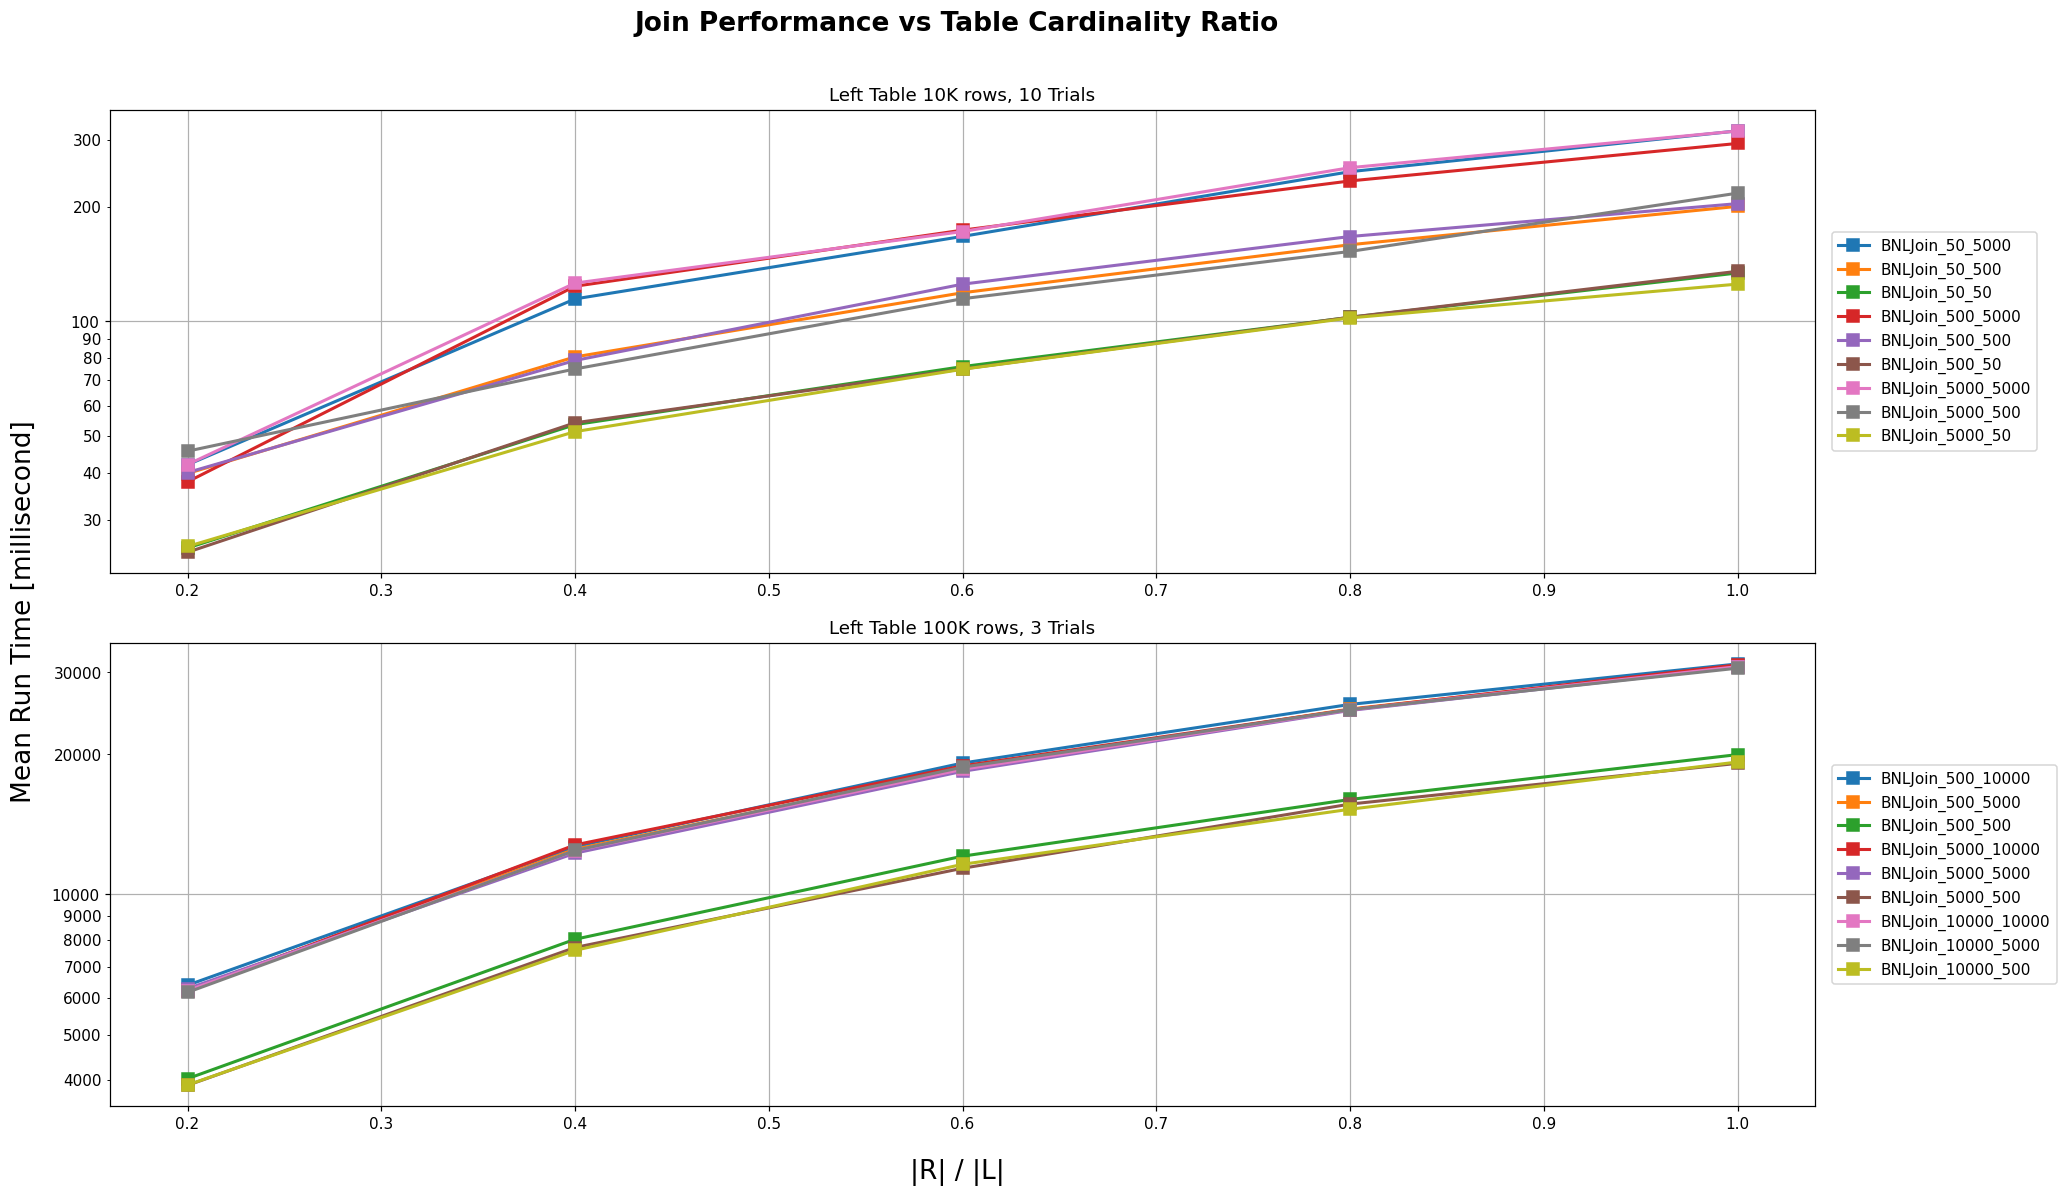

In [128]:
# Plot BNL

def bnl_name_value(t):
    bnl_name = t[0]
    parts = bnl_name.split("_")
    return (int(parts[1]), -int(parts[2]))

# One subplot for each left table size
fig, ax = plt.subplots(2, 1, figsize=(20, 12), dpi=110)

def do_subplot(lt_sz, ax, lts, nt):
    algo_map_experiment = all_data[lt_sz]
    
    for join_name, jae in  sorted(filter(lambda t: t[0].startswith("BNL"), algo_map_experiment.items()), key=bnl_name_value):
        if not join_name.lower().startswith("bnl"):
            continue

        if lts is None or nt is None:
          lts = int(jae.left_table_sizes[0])
          nt = jae.max_trial_number

        tables_ratio = jae.right_table_sizes / jae.left_table_sizes
        execution_time_avgs = jae.execution_time_avgs()
        execution_time_stddevs = jae.execution_time_stddevs()

        if join_name == "BNLJoin":
          join_name += f" (LBS={jae.left_block_sz}, RBS={jae.right_block_sz})"

        ax.errorbar(tables_ratio, execution_time_avgs, yerr=None, label=join_name, **plt_cfg)

        ax.set_title(f"Left Table {fmt_num_rows(lts)} rows, {nt} Trials")
        ax.grid(True)
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_minor_formatter(formatter)
        ax.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)

for i, lt_sz in enumerate(sorted(all_data.keys())):
    if i >= 2:
        break
    if len(all_data) > 1:
        do_subplot(lt_sz, ax[i], None, None)
    else:
        do_subplot(lt_sz, ax, None, None)

plt.subplots_adjust(hspace=0.15)
fig.text(0.51, 0.07, "|R| / |L|", ha='center', fontsize='xx-large')
fig.text(0.08, 0.5, 'Mean Run Time [millisecond]', va='center', rotation='vertical', fontsize='xx-large')
fig.text(0.51, 1-0.06, "Join Performance vs Table Cardinality Ratio", ha='center', fontsize='xx-large', fontweight='750')
plt.show()

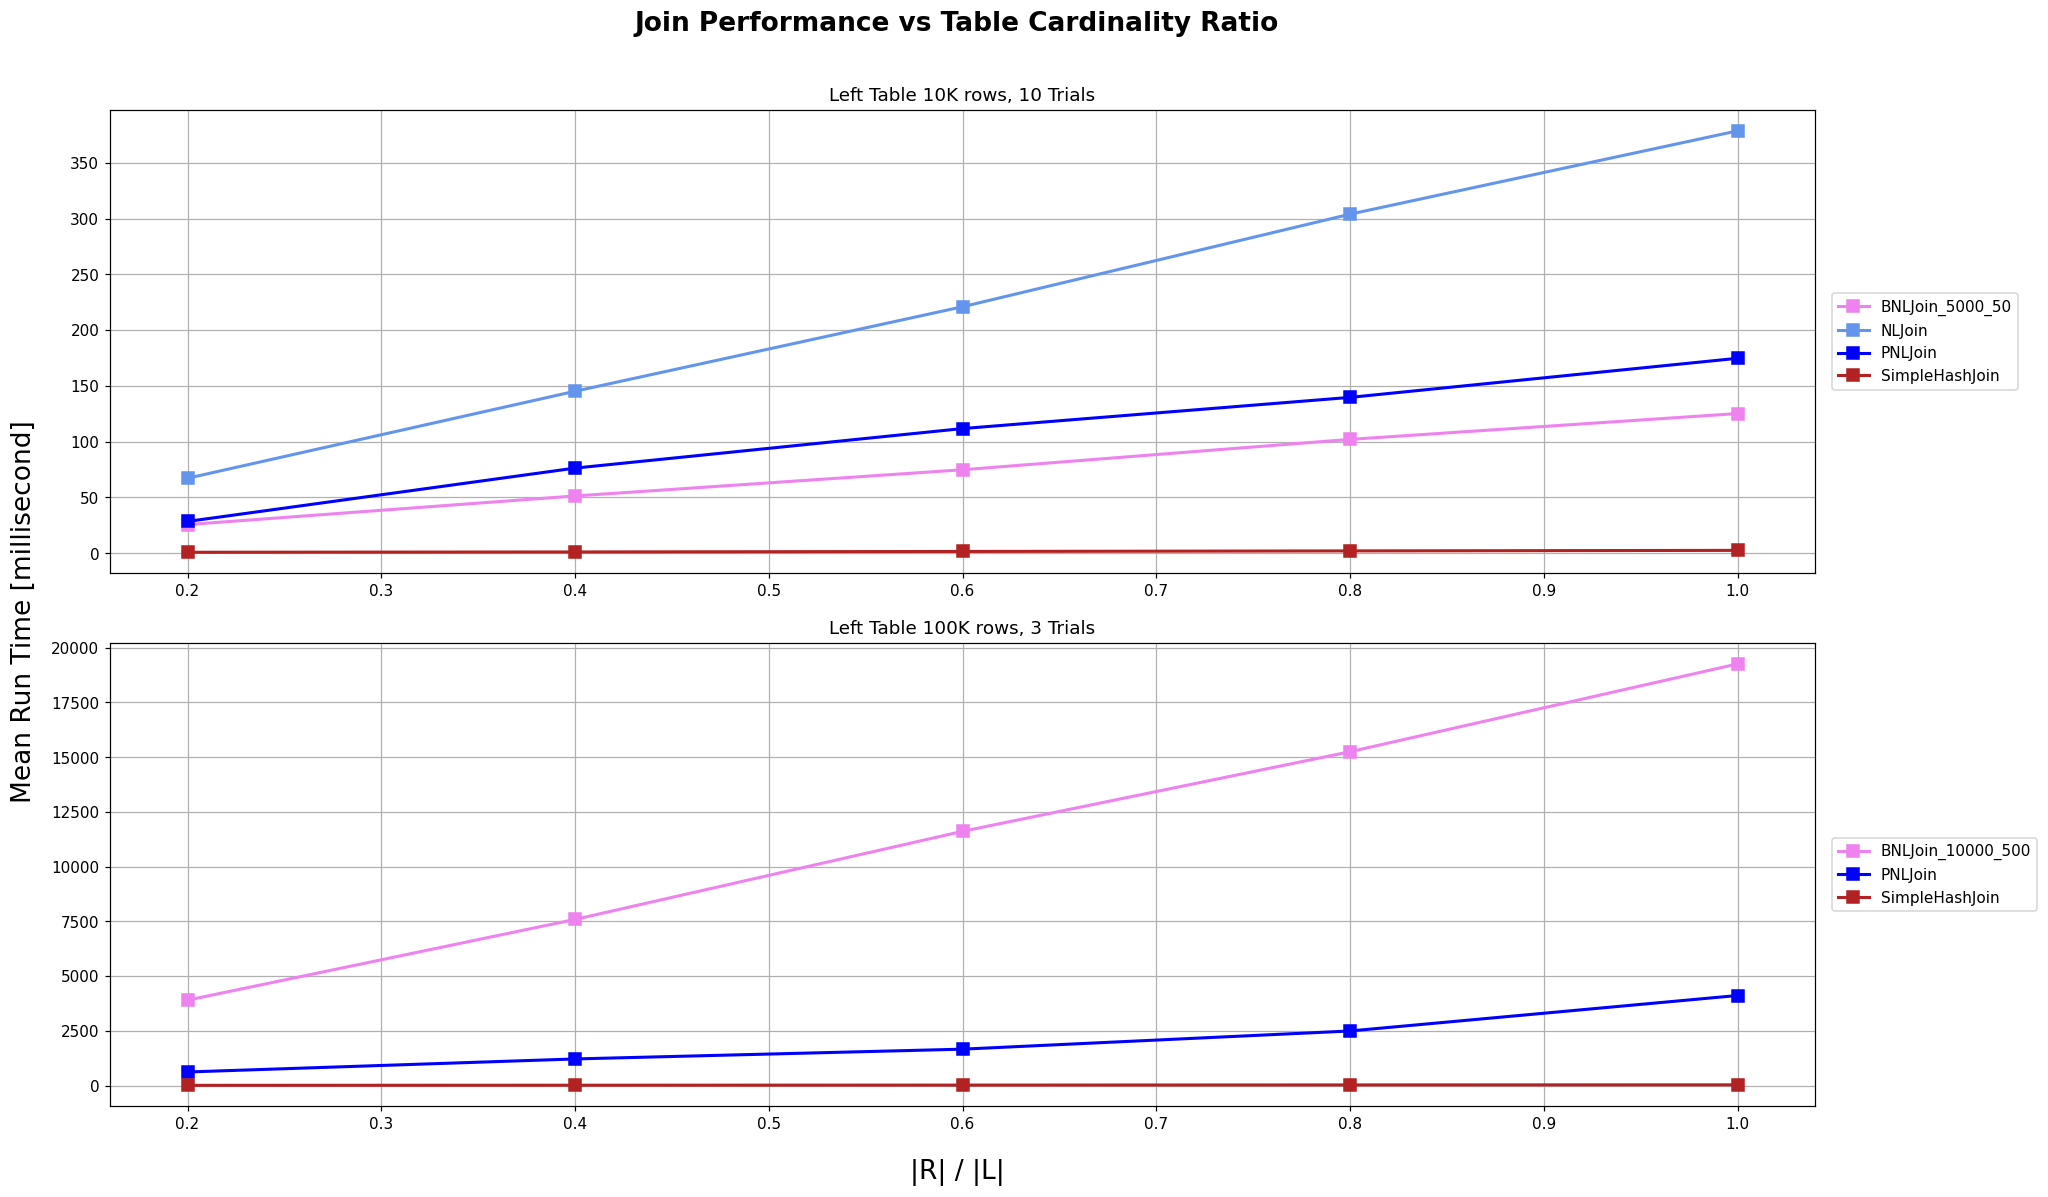

In [129]:
# Plot the full join experiment, no BNL

# One subplot for each left table size
fig, ax = plt.subplots(2, 1, figsize=(20, 12), dpi=110)

def do_subplot(lt_sz, ax, lts, nt):
    algo_map_experiment = all_data[lt_sz]
    
    ame = sorted(algo_map_experiment.items())
    for join_name, jae in ame:
        if join_name.lower().startswith("bnl") and join_name.lower() not in { "bnljoin_5000_50", "bnljoin_10000_500" } or join_name.lower() in {"parallelsimplehashjoin", "radixjoin", "parallelunaryleapfrogjoin"}:
          continue

        if lts is None or nt is None:
          lts = int(jae.left_table_sizes[0])
          nt = jae.max_trial_number

        tables_ratio = jae.right_table_sizes / jae.left_table_sizes
        execution_time_avgs = jae.execution_time_avgs()
        execution_time_stddevs = jae.execution_time_stddevs()

        if join_name == "BNLJoin":
          join_name += f" (LBS={jae.left_block_sz}, RBS={jae.right_block_sz})"

        ax.errorbar(tables_ratio, execution_time_avgs, color=color_map[join_name], yerr=None, label=join_name, **plt_cfg)

        ax.set_title(f"Left Table {fmt_num_rows(lts)} rows, {nt} Trials")
        ax.grid(True)
        ax.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)

for i, lt_sz in enumerate(sorted(all_data.keys())):
    if lt_sz <= 100_000:
        if len(all_data) > 1:
            do_subplot(lt_sz, ax[i], None, None)
        else:
            do_subplot(lt_sz, ax, None, None)

plt.subplots_adjust(hspace=0.15)
fig.text(0.51, 0.07, "|R| / |L|", ha='center', fontsize='xx-large')
fig.text(0.08, 0.5, 'Mean Run Time [millisecond]', va='center', rotation='vertical', fontsize='xx-large')
fig.text(0.51, 1-0.06, "Join Performance vs Table Cardinality Ratio", ha='center', fontsize='xx-large', fontweight='750')
plt.show()

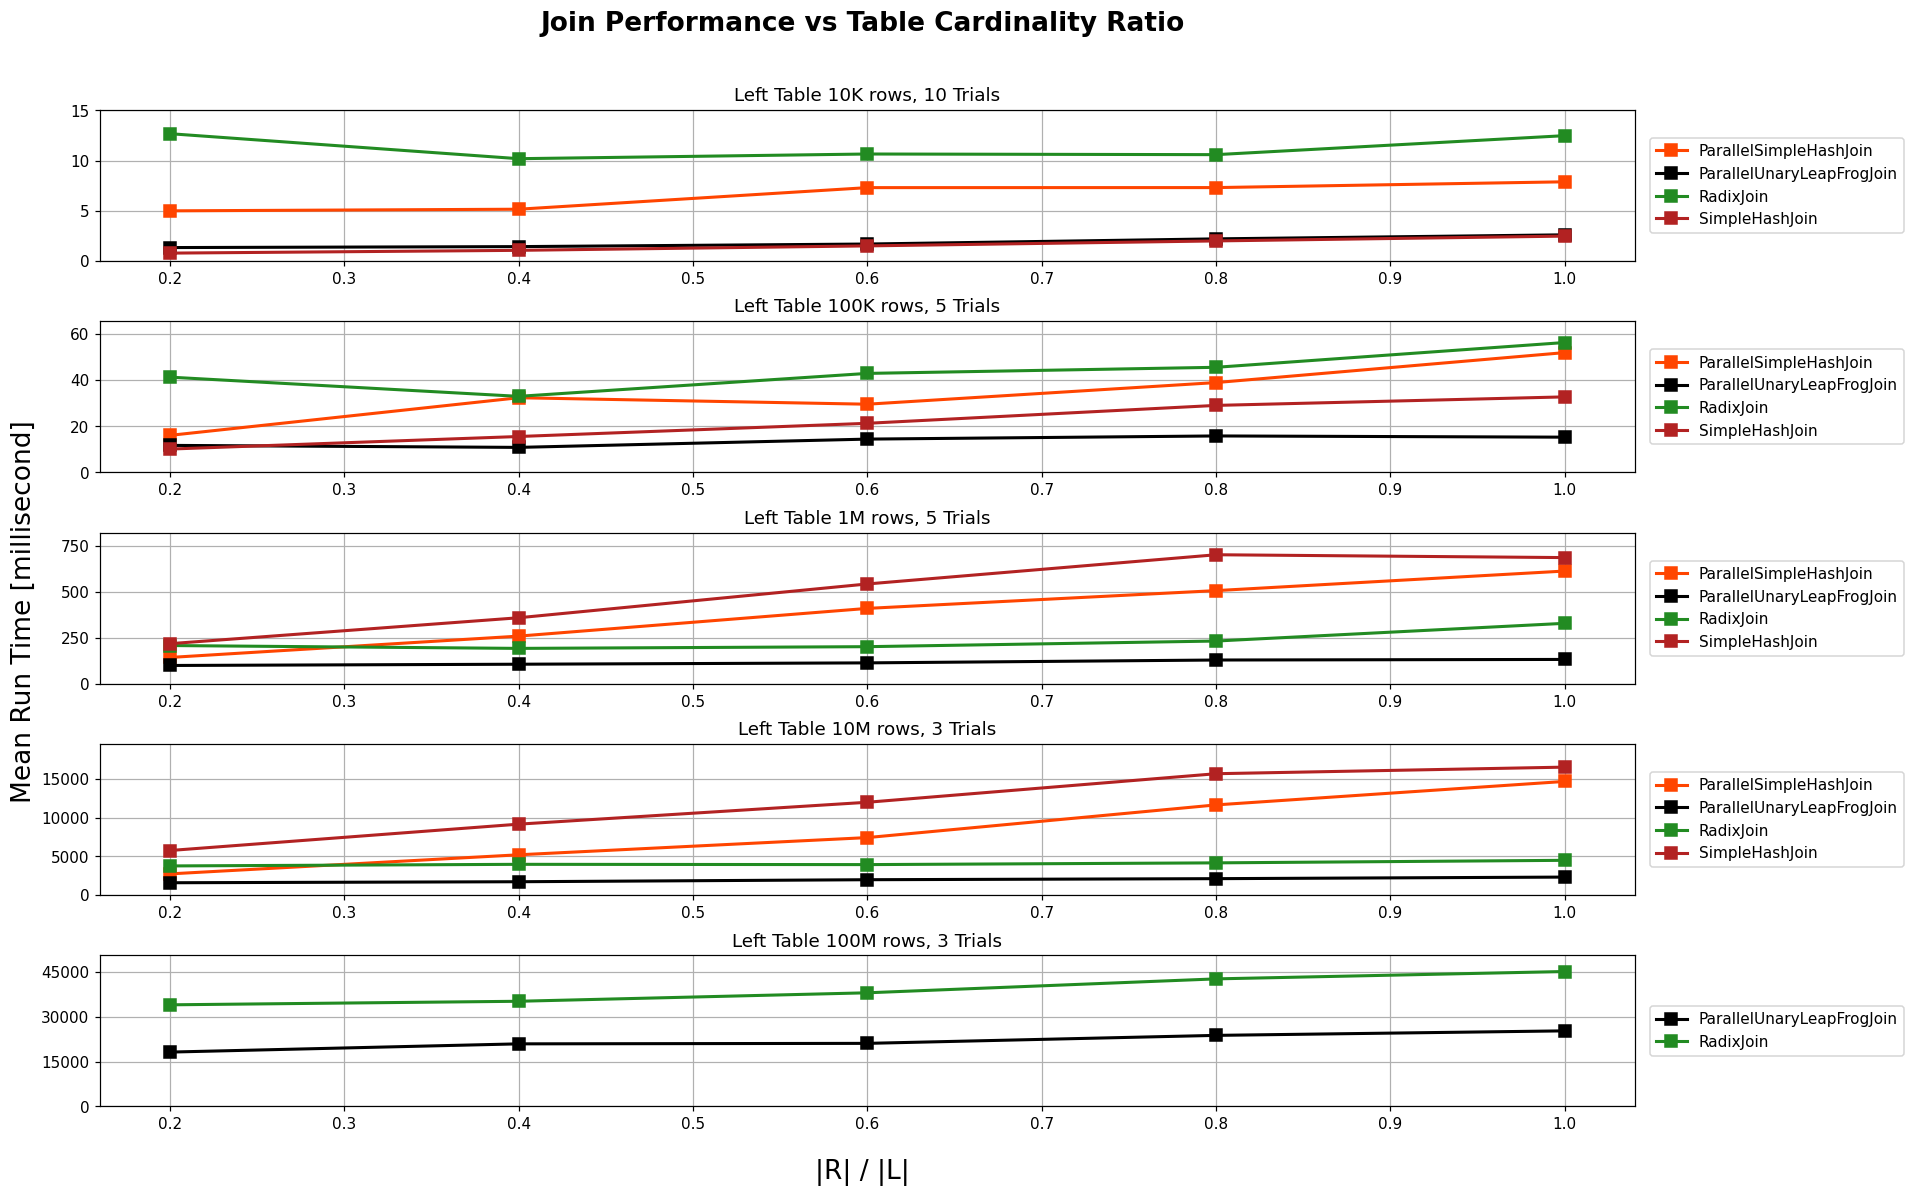

In [124]:
##### Plot the experiment, ignoring some joins, no BNL

# One subplot for each left table size
fig, ax = plt.subplots(num_left_table_sizes, 1, figsize=(18, 12), dpi=110)

# Joins to ignore in the plot
ignored_joins = {"NLJoin", "PNLJoin", "BNL"}

def do_subplot(lt_sz, ax, lts, nt):
  algo_map_experiment = all_data[lt_sz]

  ame = sorted(algo_map_experiment.items())
  for join_name, jae in ame:        
    if any(join_name.startswith(ij) for ij in ignored_joins):
      continue

    if lts is None or nt is None:
      lts = int(jae.left_table_sizes[0])
      nt = jae.max_trial_number

    tables_ratio = jae.right_table_sizes / jae.left_table_sizes
    execution_time_avgs = jae.execution_time_avgs()
    execution_time_stddevs = jae.execution_time_stddevs()

    if join_name == "BNLJoin":
      join_name += f" (LBS={jae.left_block_sz}, RBS={jae.right_block_sz})"

    ax.errorbar(tables_ratio, execution_time_avgs, color=color_map[join_name], yerr=None, label=join_name, **plt_cfg)

  ax.set_title(f"Left Table {fmt_num_rows(lts)} rows, {nt} Trials")
  ax.grid(True)
  ax.margins(y=0.2)
  ax.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
  ax.set_ylim(ymin=0)
  if lt_sz == 100_000_000:
    ax.set_yticks(np.arange(0, 50_000, 15_000))

for i, lt_sz in enumerate(sorted(all_data.keys())):
  if len(all_data) > 1:
    do_subplot(lt_sz, ax[i], None, None)
  else:
    do_subplot(lt_sz, ax, None, None)

plt.subplots_adjust(hspace=0.4)
fig.text(0.51, 0.07, "|R| / |L|", ha='center', fontsize='xx-large')
fig.text(0.08, 0.5, 'Mean Run Time [millisecond]', va='center', rotation='vertical', fontsize='xx-large')
fig.text(0.51, 1-0.06, "Join Performance vs Table Cardinality Ratio", ha='center', fontsize='xx-large', fontweight='750')
plt.show()